# Benchmark `distribute` CPG vs HS Paths

This notebook benchmarks the two backend paths from `phantom/common/distribute/__init__.py` on problem size `32` only.

- CPG path: `get_cpg_solver(...)` + `solve(...)` + `_decode_assignment(...)`
- HS path: `get_hs_solver(...)` with the same padding logic as `get_assignment_solver(...)` + `solve(...)` + `_decode_assignment(...)`


In [1]:
from __future__ import annotations

import math
import statistics
import time

import numpy as np

from phantom.common.distribute import (
    PROBLEM_RESOLUTION,
    _MAX_CPG_SIZE,
    _decode_assignment,
)
from phantom.common.distribute.cpg.solver import get_cpg_solver
from phantom.common.distribute.hs.solver import get_hs_solver

SIZES = [32]
PROBLEMS_PER_SIZE = 40
WARMUP_ROUNDS = 10
SEED = 7


In [2]:
def make_problems(size: int, count: int, rng: np.random.Generator) -> list[tuple[np.ndarray, np.ndarray]]:
    problems = []
    for _ in range(count):
        cost = rng.uniform(0.0, 100.0, size=(size, size)).astype(float)
        max_assigned = np.ones(size, dtype=float)
        problems.append((cost, max_assigned))
    return problems


def get_cpg_path_runner(n: int, m: int):
    solver = get_cpg_solver(n, m, _MAX_CPG_SIZE)
    if solver is None:
        return None

    def run(cost: np.ndarray, max_assigned: np.ndarray) -> np.ndarray:
        solver.set_total(np.zeros(m), 0)
        x = solver.solve(cost, max_assigned)
        return _decode_assignment(cost, x, max_assigned)

    return run


def run_hs_path(cost: np.ndarray, max_assigned: np.ndarray) -> np.ndarray:
    n, m = cost.shape
    n2 = math.ceil(n / PROBLEM_RESOLUTION) * PROBLEM_RESOLUTION
    m_eff = m + 1 if n < n2 else m
    m2 = math.ceil(m_eff / PROBLEM_RESOLUTION) * PROBLEM_RESOLUTION
    solver = get_hs_solver(n2, m2)
    solver.set_total(np.zeros(m), 0)
    x = solver.solve(cost, max_assigned)
    return _decode_assignment(cost, x, max_assigned)


def assignment_objective(cost: np.ndarray, chosen: np.ndarray) -> float:
    rows = np.arange(chosen.shape[0])
    return float(cost[rows, chosen].sum())


In [3]:
rng = np.random.default_rng(SEED)
all_results = []
missing_cpg_sizes = []

for size in SIZES:
    problems = make_problems(size=size, count=PROBLEMS_PER_SIZE, rng=rng)
    run_cpg_path = get_cpg_path_runner(size, size)
    cpg_available = run_cpg_path is not None

    if not cpg_available:
        missing_cpg_sizes.append(size)

    # Warm up both backends to exclude one-time init work.
    for i in range(min(WARMUP_ROUNDS, len(problems))):
        c, limit = problems[i]
        if cpg_available:
            run_cpg_path(c, limit)
        run_hs_path(c, limit)

    cpg_times = []
    hs_times = []
    objective_deltas = []

    for cost, max_assigned in problems:
        if cpg_available:
            t0 = time.perf_counter()
            cpg_chosen = run_cpg_path(cost, max_assigned)
            t1 = time.perf_counter()
            cpg_times.append((t1 - t0) * 1000.0)
        else:
            cpg_chosen = None
            t1 = time.perf_counter()

        hs_start = time.perf_counter()
        hs_chosen = run_hs_path(cost, max_assigned)
        hs_end = time.perf_counter()
        hs_times.append((hs_end - hs_start) * 1000.0)

        if cpg_chosen is not None:
            cpg_obj = assignment_objective(cost, cpg_chosen)
            hs_obj = assignment_objective(cost, hs_chosen)
            objective_deltas.append(cpg_obj - hs_obj)

    cpg_ms_mean = statistics.mean(cpg_times) if cpg_times else float("nan")
    hs_ms_mean = statistics.mean(hs_times)

    all_results.append({
        "size": size,
        "cpg_available": cpg_available,
        "cpg_ms_mean": cpg_ms_mean,
        "cpg_ms_p95": np.percentile(cpg_times, 95) if cpg_times else float("nan"),
        "hs_ms_mean": hs_ms_mean,
        "hs_ms_p95": np.percentile(hs_times, 95),
        "speedup_hs_over_cpg": (cpg_ms_mean / hs_ms_mean) if cpg_times else float("nan"),
        "avg_obj_delta_cpg_minus_hs": statistics.mean(objective_deltas) if objective_deltas else float("nan"),
    })

if missing_cpg_sizes:
    print(f"CPG unavailable for sizes: {missing_cpg_sizes}")

all_results


2026-02-21 03:54:13.562 | INFO     | phantom.common.distribute.cpg.solver:_init_cpg_solver_for_log:269 - Using CVXPYGEN assignment solver assign5 with size 32x32
2026-02-21 03:54:13.581 | INFO     | phantom.common.distribute.hs.solver:__init__:12 - Compiling highspy problem with n=32, m=32, include_total=True


[{'size': 32,
  'cpg_available': True,
  'cpg_ms_mean': 16.18318749970058,
  'cpg_ms_p95': np.float64(20.2819499951147),
  'hs_ms_mean': 1.275112499934039,
  'hs_ms_p95': np.float64(1.5597400022670627),
  'speedup_hs_over_cpg': 12.691576233891306,
  'avg_obj_delta_cpg_minus_hs': 0.0}]

In [4]:
try:
    import pandas as pd

    df = pd.DataFrame(all_results)
    display(df.round(4))
except Exception:
    for row in all_results:
        print(row)


,size,cpg_available,cpg_ms_mean,cpg_ms_p95,hs_ms_mean,hs_ms_p95,speedup_hs_over_cpg,avg_obj_delta_cpg_minus_hs
0,32,True,16.1832,20.2819,1.2751,1.5597,12.6916,0.0


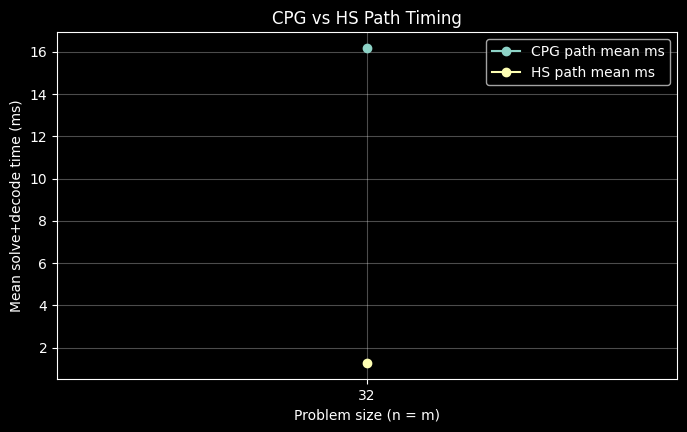

In [5]:
try:
    import matplotlib.pyplot as plt

    sizes = [row["size"] for row in all_results]
    cpg_means = [row["cpg_ms_mean"] for row in all_results]
    hs_means = [row["hs_ms_mean"] for row in all_results]

    plt.figure(figsize=(8, 4.5))
    plt.plot(sizes, cpg_means, marker="o", label="CPG path mean ms")
    plt.plot(sizes, hs_means, marker="o", label="HS path mean ms")
    plt.xscale("log", base=2)
    plt.xticks(sizes, sizes)
    plt.xlabel("Problem size (n = m)")
    plt.ylabel("Mean solve+decode time (ms)")
    plt.title("CPG vs HS Path Timing")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()
except Exception as ex:
    print(f"Skipping plot: {ex}")
